<a href="https://www.kaggle.com/code/krippanandhini/bank-loan-risk?scriptVersionId=162636953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-loan-cleaned-ver1/Bankloan_Cleanedv1.csv


In [2]:
#data-viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
#ml libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/kaggle/input/bank-loan-cleaned-ver1/Bankloan_Cleanedv1.csv')
df.head()

,age,employ,address,income,debtinc,creddebt,othdebt,ed,default
0,41.0,17,12,176.0,9.3,11.359392,5.008608,3.0,1
1,27.0,10,6,31.0,17.3,1.362202,4.000798,1.0,0
2,40.0,15,7,NaN,5.5,0.856075,2.168925,1.0,0
3,41.0,15,14,120.0,2.9,2.658720,0.821280,NaN,0
4,24.0,2,0,28.0,17.3,1.787436,3.056564,2.0,1


## Column description:

- Age: Age in years.

- Ed: 1-Did not complete high school 2-High school degree 3-Some college 4-College degree 5-Post-undergraduate degree

- Employ: Years with current employer

- Address: Years at current address

- Income: Household income in thousands

- Debtinc: Debt to income ratio (x100)

- Creddebt: Credit card debt in thousands

- Othdebt: Other debt in thousands

- Default: The "Default" field is the target variable, indicating previously defaulted. It takes binary values, with 1 typically denoting a "bad" default status and 0 representing a "good" repayment history.

In [4]:
df.shape

(700, 9)

In [5]:
df.columns

Index(['age', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt',
       'ed', 'default'],
      dtype='object')

In [6]:
# Calculate the number of rows and columns for the subplot grid
num_cols = 3
num_rows = math.ceil(len(df.columns) / num_cols)

# Create a new figure with subplots
fig = make_subplots(rows=num_rows, cols=num_cols)

# Iterate over each column in the DataFrame
for i, column in enumerate(df.columns):
    # Calculate the subplot index
    row_index = math.floor(i / num_cols) + 1
    col_index = (i % num_cols) + 1
    
    # Check if the column is numeric (excluding object and categorical columns)
    if pd.api.types.is_numeric_dtype(df[column]):
        # Plot histogram using Plotly Express and add it to the subplot
        fig.add_trace(go.Histogram(x=df[column], name=column), row=row_index, col=col_index)
        # Add column name as subplot title
        fig.update_xaxes(title_text=column, row=row_index, col=col_index)

# Update layout to adjust subplot titles and axis labels
fig.update_layout(
    title="Histograms of Dataset Columns",
    height=800,
    width=800,
    showlegend=False
)

# Show the plot
fig.show()


We see that all the columns are left skewed.

In [7]:
df.isna().sum()

age         20
employ       0
address      0
income      37
debtinc      0
creddebt     0
othdebt      0
ed          20
default      0
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.isna().sum()

age         0
employ      0
address     0
income      0
debtinc     0
creddebt    0
othdebt     0
ed          0
default     0
dtype: int64

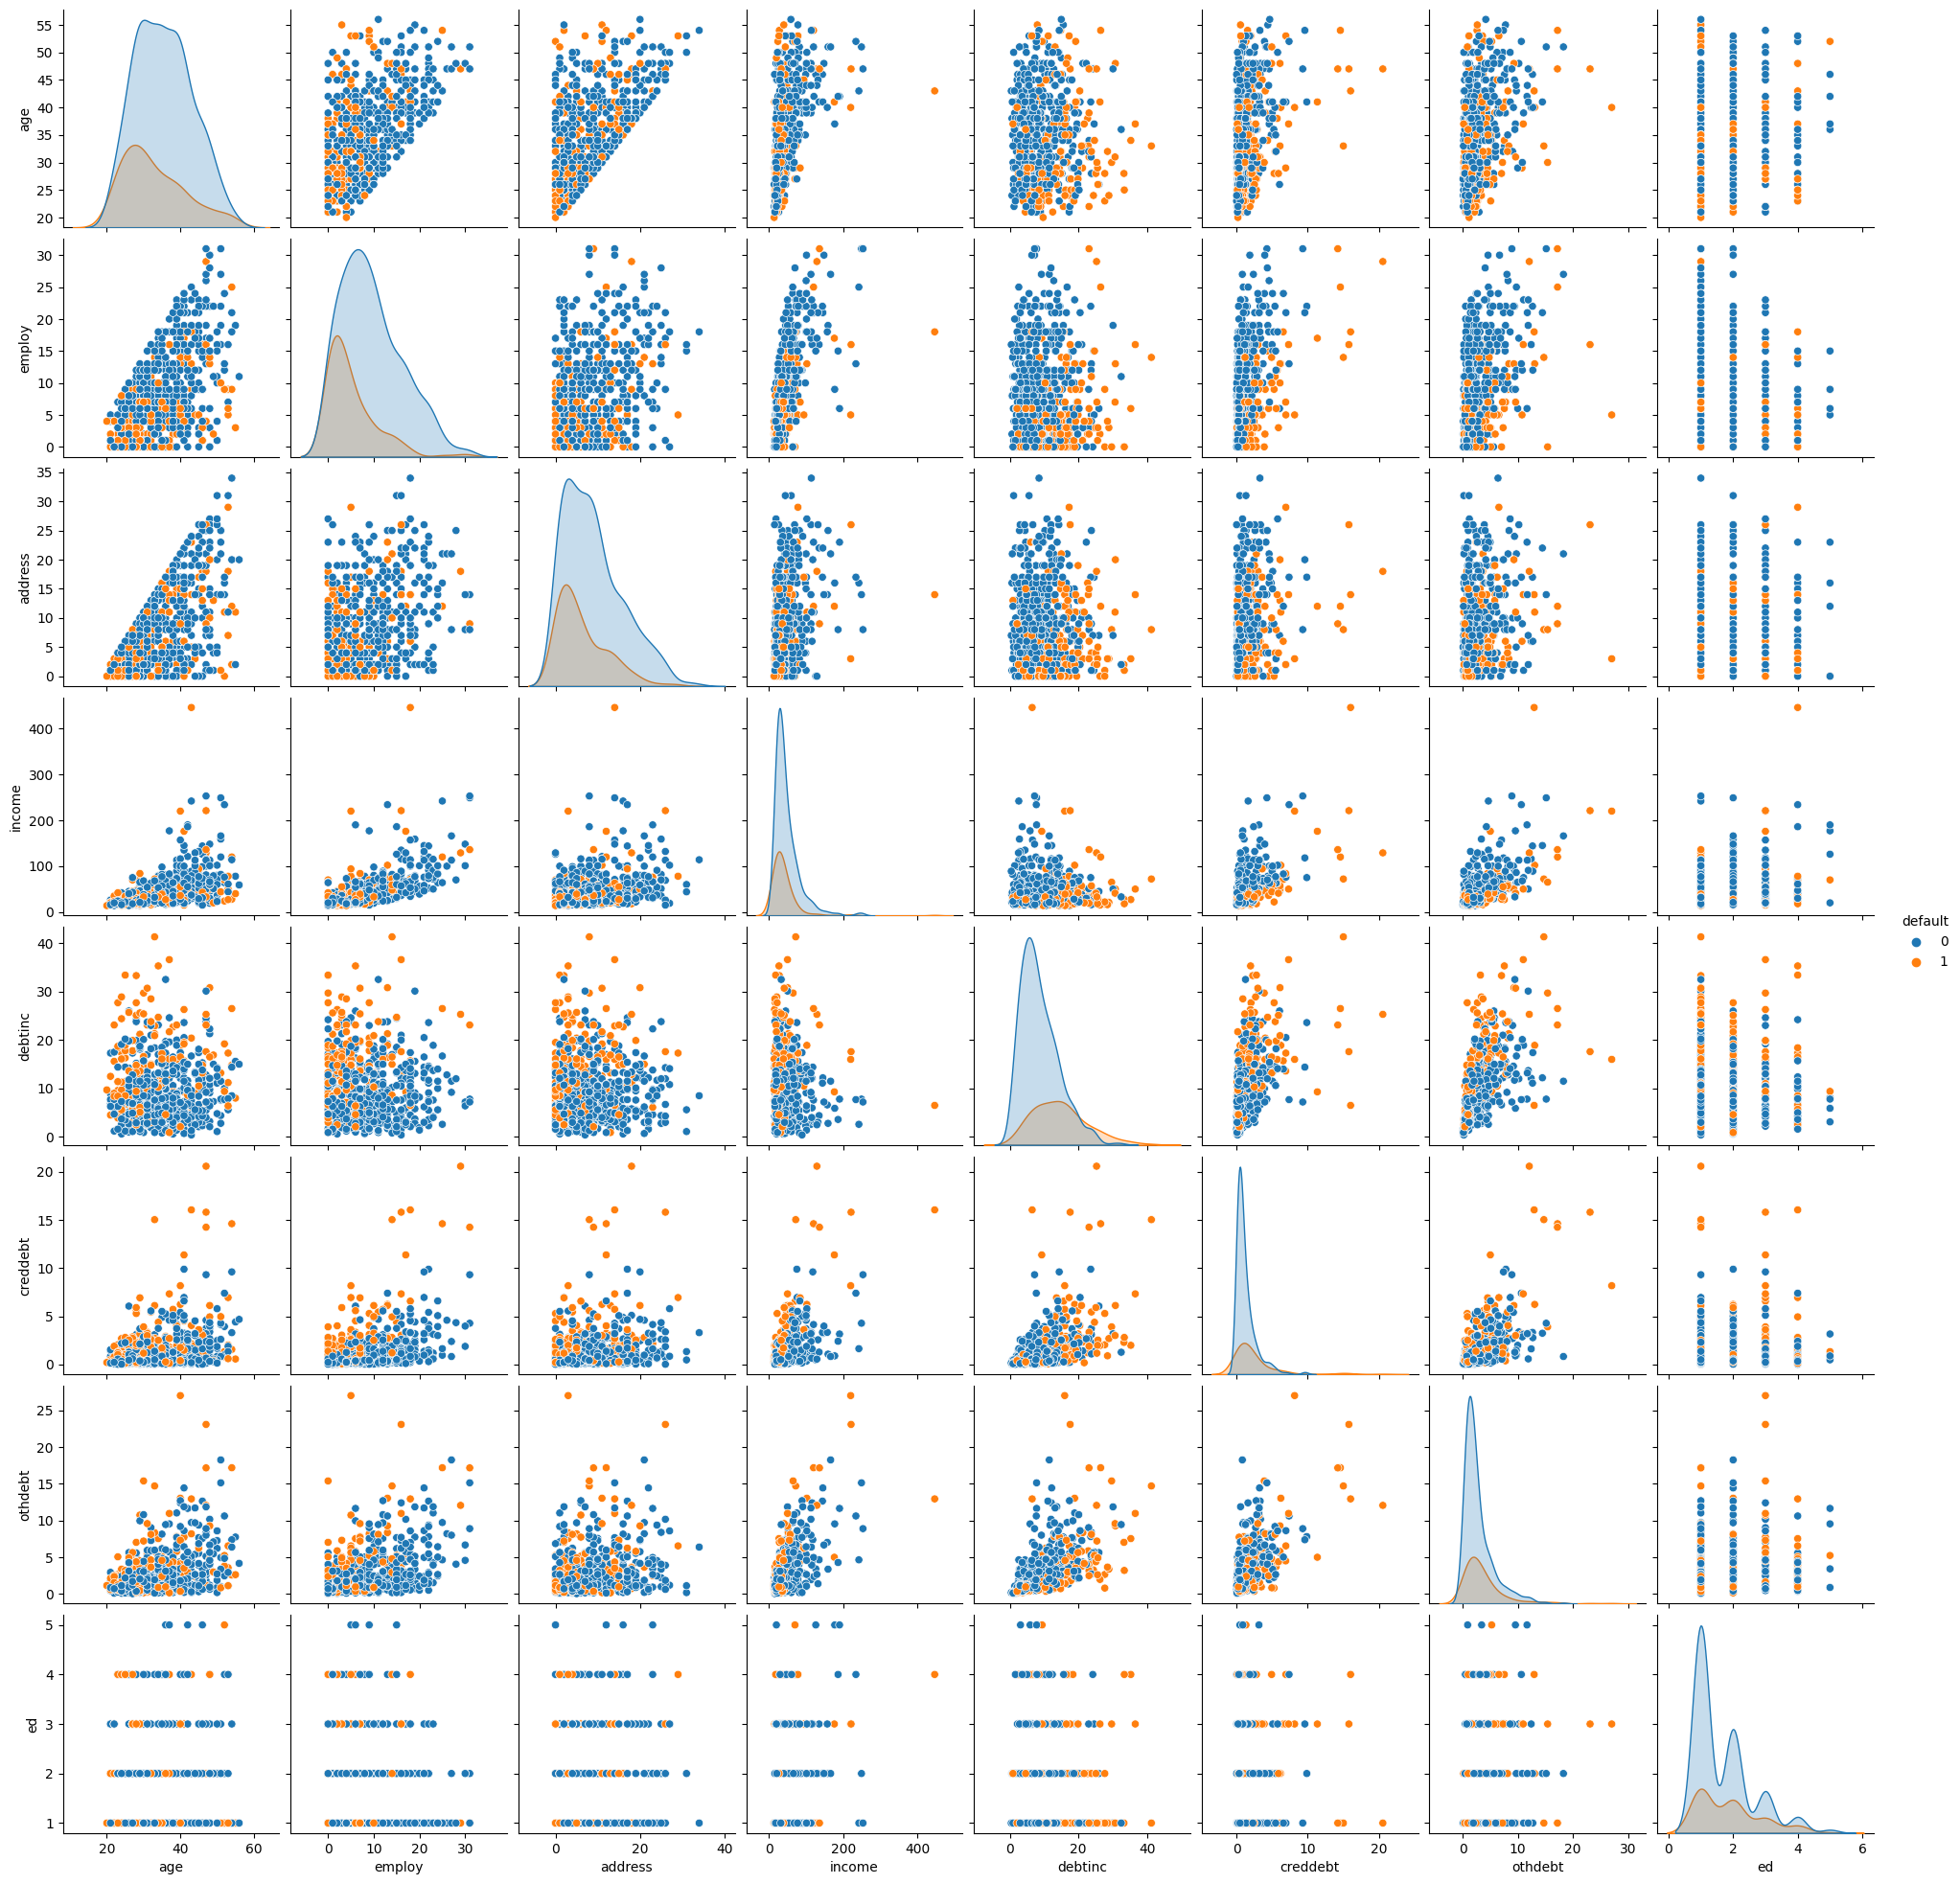

In [10]:
sns.pairplot(df, hue = 'default')

In [11]:
df.describe()

,age,employ,address,income,debtinc,creddebt,othdebt,ed,default
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,34.848000,8.352000,8.240000,45.635200,10.238880,1.543640,3.020191,1.720000,0.259200
std,8.011666,6.741871,6.801678,37.886318,6.754012,2.146588,3.156205,0.921607,0.438547
min,20.000000,0.000000,0.000000,14.000000,0.400000,0.011696,0.045584,1.000000,0.000000
25%,28.000000,3.000000,3.000000,24.000000,5.100000,0.369974,1.048346,1.000000,0.000000
50%,34.000000,7.000000,7.000000,34.000000,8.700000,0.849024,1.995136,1.000000,0.000000
75%,40.000000,12.000000,12.000000,54.000000,14.000000,1.875168,3.946800,2.000000,1.000000
max,56.000000,31.000000,34.000000,446.000000,41.300000,20.561310,27.033600,5.000000,1.000000


In [12]:
df['default'].value_counts()

default
0    463
1    162
Name: count, dtype: int64

In [13]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Plot correlation matrix using Plotly Express with annotations
fig = px.imshow(corr_matrix,
                labels=dict(color="Correlation"),
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale=px.colors.diverging.RdBu,
                zmin=-1, zmax=1)

# Add annotations to the plot
annotations = []
for i, row in enumerate(corr_matrix.values):
    for j, value in enumerate(row):
        annotations.append(
            dict(
                text=str(round(value, 2)),
                x=corr_matrix.columns[j],
                y=corr_matrix.index[i],
                xref='x1', yref='y1',
                showarrow=False,
                font=dict(color='black' if abs(value) < 0.5 else 'white')
            )
        )

fig.update_layout(annotations=annotations)

# Customize layout
fig.update_layout(
    title="Correlation Matrix with Annotations",
    width=800,
    height=600,
    xaxis_title="Features",
    yaxis_title="Features"
)

# Show plot
fig.show()


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625 entries, 0 to 698
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       625 non-null    float64
 1   employ    625 non-null    int64  
 2   address   625 non-null    int64  
 3   income    625 non-null    float64
 4   debtinc   625 non-null    float64
 5   creddebt  625 non-null    float64
 6   othdebt   625 non-null    float64
 7   ed        625 non-null    float64
 8   default   625 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 48.8 KB


In [15]:
# Shuffle the indices of the DataFrame
indices = np.random.permutation(df.shape[0])

# Calculate the number of samples for training and testing sets
train_size = int(0.8 * df.shape[0])

# Split the indices into training and testing sets
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the dataset based on the selected indices
train_df = df.iloc[train_indices]
test_df = df.iloc[test_indices]

# Separate features and target variable for training and testing sets
x_train = train_df.drop('default', axis=1)
y_train = train_df['default']
x_test = test_df.drop('default', axis=1)
y_test = test_df['default']

In [16]:
Log_reg = LogisticRegression()
Log_reg.fit(x_train,y_train)
y_pred = Log_reg.predict(x_test)

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        91
           1       0.79      0.44      0.57        34

    accuracy                           0.82       125
   macro avg       0.81      0.70      0.72       125
weighted avg       0.81      0.82      0.80       125



In [18]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train,y_train)
y_pred1 = gbc.predict(x_test)

In [19]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86        91
           1       0.67      0.35      0.46        34

    accuracy                           0.78       125
   macro avg       0.73      0.64      0.66       125
weighted avg       0.76      0.78      0.75       125



In [20]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred2 = rfc.predict(x_test)

In [21]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87        91
           1       0.72      0.38      0.50        34

    accuracy                           0.79       125
   macro avg       0.76      0.66      0.68       125
weighted avg       0.78      0.79      0.77       125



In [22]:
feature_importance = gbc.feature_importances_
sorted_idx = np.argsort(feature_importance)

In [23]:
# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Create a DataFrame to hold the feature importances and their corresponding feature names
data = {'Feature': x_train.columns[sorted_idx], 'Relative Importance': feature_importance[sorted_idx]}
df_importance = pd.DataFrame(data)

# Create a horizontal bar plot using Plotly Express
fig = px.bar(df_importance, x='Relative Importance', y='Feature', orientation='h',
             title='Variable Importance')

# Show the plot
fig.show()